<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Engenharia Financeira com Inteligência Artificial</font>
## <font color='blue'>Projeto 8</font>
## <font color='blue'>Estratégia de Trading Usando Inteligência Artificial com Aprendizado Por Reforço</font>

## Instalando e Carregando Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

https://pypi.org/project/gymnasium/

In [2]:
#!pip install -q gymnasium

In [3]:
#!pip install -q gym_anytrading

https://pypi.org/project/stable-baselines3/

In [4]:
#!pip install -q stable_baselines3

In [5]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [6]:
# Imports
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
import stable_baselines3
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO
import warnings
warnings.filterwarnings('ignore')

In [7]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Módulo de Extração dos Dados Históricos

In [8]:
# Função para baixar os dados históricos do Yahoo Finance
def dsa_get_stock_data(ticker):
    
    # Define o intervalo 
    start_date = '2014-08-23'
    end_date = '2024-08-23'
    
    # Baixar os dados históricos do Yahoo Finance
    dados = yf.download(ticker, start = start_date, end = end_date, auto_adjust = True)
    
    # Filtrar a coluna 'Close' 
    dados = dados[['Close']]
    
    return dados

A função dsa_get_stock_data(ticker) tem o objetivo de baixar os dados históricos de ações de uma empresa a partir do Yahoo Finance. Aqui está o que ela faz:

Define as datas de início e término para 10 anos de dados.

Usa a função yf.download() da biblioteca yfinance para baixar os dados históricos para o "ticker" (símbolo da ação) passado como argumento. O período é definido pelas variáveis start_date e end_date.

Após baixar os dados, a função filtra apenas a coluna 'Close', que contém os valores de fechamento da ação para cada dia dentro do período.

Retorna esses dados filtrados, que incluem apenas os preços de fechamento da ação para o período solicitado.

In [9]:
# Obter dados com a função
df_dsa = dsa_get_stock_data('MSFT')

[*********************100%***********************]  1 of 1 completed


In [10]:
# Shape
df_dsa.shape

(2516, 1)

In [11]:
# Primeiros registros
df_dsa.head()

Price,Close
Ticker,MSFT
Date,
2014-08-25,38.396442
2014-08-26,38.260429
2014-08-27,38.141415
2014-08-28,38.149929
2014-08-29,38.617451


In [12]:
# Últimos registros
df_dsa.tail()

Price,Close
Ticker,MSFT
Date,
2024-08-16,416.034515
2024-08-19,419.076721
2024-08-20,422.327698
2024-08-21,421.671570
2024-08-22,413.131500


## Janela de Lookback

In [13]:
# Define os parâmetros
window_size = 10
start_index = window_size
end_index = len(df_dsa)

A "janela de lookback" (ou janela de retrospectiva) é um conceito utilizado em séries temporais e modelagem preditiva. Ela refere-se ao número de períodos anteriores (dias, semanas, meses, etc.) que você olha para trás para fazer uma previsão ou análise.

Neste contexto:

window_size = 10: Define o tamanho da janela de lookback como 10, o que significa que, a cada ponto no tempo, você está observando os 10 períodos anteriores (dias, no caso de dados diários) para fazer alguma análise ou previsão. A ideia é que, para prever o próximo valor ou realizar alguma análise estatística, você usa os dados dos últimos 10 dias.

start_index = window_size: Define o índice de início como o tamanho da janela. Isso é comum em algoritmos que utilizam janelas deslizantes, porque você não pode fazer uma análise antes de ter uma quantidade suficiente de dados (neste caso, 10 períodos).

end_index = len(df_dsa): Define o índice final como o comprimento total do DataFrame df_dsa, ou seja, o último ponto dos dados disponíveis.

## Criação do Ambiente de Negociação

Leia o material sobre Aprendizado Por Reforço nos ebooks do Capítulo 14 do curso.

Criamos um ambiente de simulação para negociação de ações utilizando a biblioteca gymnasium, que é amplamente usada para treinar agentes de aprendizado por reforço. 

https://gym-trading-env.readthedocs.io/en/latest/

In [14]:
# Cria o ambiente com o espaço de obervação (versão anterior do pacote gym)
#dsaenv = gym.make('stocks-v0', 
#                  df = df_dsa, 
#                  window_size = window_size, 
#                  frame_bound = (start_index, end_index))

In [15]:
# Importa o StocksEnv
from gym_anytrading.envs import StocksEnv

# Classe customizada (necessária na nova versão do pacote gym_anytrading)
class CustomStocksEnv(StocksEnv):
    
    def _process_data(self):
        
        # Transforma o DataFrame em vetor 1-D de preços
        prices = self.df['Close'].to_numpy()
        
        # Ajusta os limites de frame
        start = self.frame_bound[0] - self.window_size
        end   = self.frame_bound[1]
        prices = prices[start:end]
        
        # Calcula a variação ao longo do eixo 0
        diff = np.insert(np.diff(prices, axis=0), 0, 0)
        
        # Empilha preço e variação
        signal_features = np.column_stack((prices, diff))
        
        return prices.astype(np.float32), signal_features.astype(np.float32)

In [16]:
# Cria o ambiente com o espaço de obervação
dsaenv = CustomStocksEnv(df = df_dsa,
                         window_size = window_size,
                         frame_bound = (start_index, end_index))

In [17]:
print("Espaço de Obervação:", dsaenv.observation_space)

Espaço de Obervação: Box(-1e+10, 1e+10, (10, 2), float32)


Aqui está uma explicação detalhada do que está acontecendo:

dsaenv = gym.make('stocks-v0', ...): Essa linha cria um ambiente personalizado de simulação para ações chamado 'stocks-v0'. Ele é fornecido por uma versão estendida da biblioteca gym, que permite a simulação de ambientes específicos para finanças, como o mercado de ações. Este ambiente simula o comportamento do mercado com base nos dados fornecidos.

Parâmetros do ambiente:

df = df_dsa: O ambiente utiliza o DataFrame df_dsa que contém os dados históricos das ações (preços de fechamento) para a simulação.

window_size = window_size: Define o tamanho da janela de observação como 10 dias, que será usada para fornecer ao agente os dados dos últimos 10 dias durante a simulação.

frame_bound = (start_index, end_index): Define os limites de tempo para a simulação, começando no índice start_index (equivalente a 10, para garantir que haja uma janela inicial) e terminando no end_index (último ponto dos dados). Isso significa que a simulação só considerará os dados dentro deste intervalo de tempo.

print("Espaço de Observação:", dsaenv.observation_space): Após a criação do ambiente, esta linha imprime o espaço de observação do ambiente, que indica o formato e os limites dos dados que o agente pode observar a cada passo da simulação. O espaço de observação define os dados que o agente de aprendizado por reforço verá a cada interação com o ambiente (nesse caso, os dados de mercado de ações dentro da janela de 10 dias).

## Definindo o Saldo Inicial Para Negociação e Outros Parâmetros

In [18]:
# Inicializa os parâmetros
saldo = 100000
historico_saldo = [saldo]
num_acoes_manter = 0
status_decisao = {Actions.Sell: 0, Actions.Buy: 0}

**saldo = 100000**: Inicializa o saldo (capital em dinheiro) do agente ou investidor com o valor de 100.000. Esse saldo é o capital inicial disponível para comprar e vender ações durante a simulação.

**historico_saldo = [saldo]**: Cria uma lista chamada historico_saldo e coloca o saldo inicial como o primeiro item da lista. Essa lista vai registrar o saldo ao longo do tempo, permitindo acompanhar como o saldo do investidor evolui à medida que ele faz operações de compra e venda de ações.

**num_acoes_manter = 0**: Inicializa o número de ações que o agente ou investidor possui com 0. Isso indica que, no início da simulação, ele não possui nenhuma ação. Esse valor será atualizado conforme o investidor compra ou vende ações.

**status_decisao = {Actions.Sell: 0, Actions.Buy: 0}**: Inicializa um dicionário chamado status_decisao, onde as chaves são as ações possíveis que o agente pode tomar (vender ou comprar) e os valores são inicializados em 0. Isso é usado para registrar a frequência ou o estado das decisões tomadas pelo agente, como quantas vezes ele decidiu comprar ou vender durante a simulação. 

In [19]:
# Reinicializa o ambiente de simulação de ações e configura um ponto de partida para o agente
observation, info = dsaenv.reset(seed = 42)

## Criação e Treinamento do Modelo

Veja os detalhes sobre PPO no videobook do Capítulo 14 do curso.

https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

In [20]:
# Cria o modelo PPO
modelo_dsa_trading = PPO('MlpPolicy', dsaenv, seed = 42, verbose = 1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [21]:
# Treina o modelo
modelo_dsa_trading.learn(total_timesteps = 10000)

------------------------------
| time/              |       |
|    fps             | 10138 |
|    iterations      | 1     |
|    time_elapsed    | 0     |
|    total_timesteps | 2048  |
------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.5e+03     |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 5784        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017358378 |
|    clip_fraction        | 0.0123      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | 0.000607    |
|    learning_rate        | 0.0003      |
|    loss                 | 4.97        |
|    n_updates            | 10          |
|    policy_gradient_loss |

## Executando o Agente de Trading no Ambiente de Negociação

In [22]:
# Certifique-se de inicializar num_acoes_manter e saldo como floats
step = 0
num_acoes_manter = 0.0  
saldo = float(saldo)     

# Loop principal que continua até que a simulação termine
while True:
    
    # O modelo faz uma previsão (decisão) com base na observação atual
    action, _states = modelo_dsa_trading.predict(observation)
    
    # Obtém o preço atual da ação com base no tick (índice temporal) do ambiente
    current_price = float(dsaenv.unwrapped.prices[dsaenv.unwrapped._current_tick])
    
    # Executa a decisão no ambiente e retorna a nova observação, recompensa e outros indicadores
    observation, reward, terminated, truncated, info = dsaenv.step(action)
    
    # Define o montante da negociação como 10% do saldo atual
    trade_amount = float(saldo * 0.10)

    # Verifica se a decisão é de compra
    if action == Actions.Buy.value:
        
        # Calcula o número de ações a serem compradas com base no montante de negociação e preço atual
        shares_to_buy = float(trade_amount / current_price)
        
        # Atualiza o número de ações que o agente mantém
        num_acoes_manter += shares_to_buy

        # Deduz o valor do saldo correspondente ao montante negociado
        saldo -= trade_amount
        
        # Imprime os detalhes da compra, incluindo o número de ações e o novo saldo
        print(f"{step}: Comprar {shares_to_buy:.2f} ações por ${current_price:.2f} cada uma | Saldo: ${saldo:.2f}")

    # Verifica se a decisão é de venda e se há ações para vender
    elif action == Actions.Sell.value and num_acoes_manter > 0.0:
                
        # Atualiza o saldo ao vender todas as ações mantidas pelo preço atual
        saldo += num_acoes_manter * current_price
        
        # Imprime os detalhes da venda, incluindo o número de ações vendidas e o novo saldo
        print(f"{step}: Vender {num_acoes_manter:.2f} ações por ${current_price:.2f} cada uma | Saldo: ${saldo:.2f}")
        
        # Zera o número de ações mantidas após a venda
        num_acoes_manter = 0.0

    # Caso contrário, mantém a posição e imprime o status
    else:
        
        # Imprime que o agente está mantendo a posição e exibe o preço corrente da ação e o saldo
        print(f"{step}: Manter | Valor corrente da ação: ${current_price:.2f} | Saldo: ${saldo:.2f}")
    
    # Atualiza o status da decisão (compra ou venda) no dicionário de status
    status_decisao[Actions(action)] += 1

    # Adiciona o saldo atual ao histórico de saldo
    historico_saldo.append(saldo)

    # Incrementa o passo para o próximo ciclo
    step += 1
    
    # Verifica se a simulação terminou ou foi truncada (interrompida) e, se verdadeiro, quebra o loop
    if terminated or truncated:
        break

0: Comprar 251.04 ações por $39.83 cada uma | Saldo: $90000.00
1: Vender 251.04 ações por $39.32 cada uma | Saldo: $99871.57
2: Comprar 254.04 ações por $39.31 cada uma | Saldo: $89884.41
3: Comprar 223.94 ações por $40.14 cada uma | Saldo: $80895.97
4: Comprar 199.01 ações por $40.65 cada uma | Saldo: $72806.37
5: Comprar 179.80 ações por $40.49 cada uma | Saldo: $65525.74
6: Comprar 161.44 ações por $40.59 cada uma | Saldo: $58973.16
7: Comprar 143.06 ações por $41.22 cada uma | Saldo: $53075.85
8: Comprar 128.65 ações por $41.26 cada uma | Saldo: $47768.26
9: Comprar 118.17 ações por $40.42 cada uma | Saldo: $42991.44
10: Vender 1408.11 ações por $40.53 cada uma | Saldo: $100058.97
11: Comprar 243.81 ações por $41.04 cada uma | Saldo: $90053.07
12: Comprar 223.78 ações por $40.24 cada uma | Saldo: $81047.76
13: Comprar 199.98 ações por $40.53 cada uma | Saldo: $72942.99
14: Comprar 180.02 ações por $40.52 cada uma | Saldo: $65648.69
15: Comprar 161.09 ações por $40.75 cada uma | Sal

## Decisão Final do Agente

In [23]:
# Se ainda tivermos ações no final da simulação, vendemos todas elas
if num_acoes_manter > 0:
    
    # Atualiza o saldo ao vender todas as ações mantidas pelo preço corrente
    saldo += num_acoes_manter * current_price
    
    # Imprime os detalhes da venda final, incluindo o número de ações e o saldo atualizado
    print(f"Venda Final de {num_acoes_manter:.2f} ações por ${current_price:.2f} cada uma | Saldo: ${saldo:.2f}")
    
    # Zera o número de ações mantidas após a venda final
    num_acoes_manter = 0

Venda Final de 113.42 ações por $421.67 cada uma | Saldo: $138600.55


In [24]:
# Fecha o ambiente
dsaenv.close()

In [25]:
# Salva o modelo em disco
modelo_dsa_trading.save("modelo_dsa_trading")

## Resultado Obtido Pelo Agente de Trading

In [26]:
print("Decisões Tomadas:", status_decisao)
print(f"Saldo Final: ${saldo:.2f}")

Decisões Tomadas: {<Actions.Sell: 0>: 637, <Actions.Buy: 1>: 1648}
Saldo Final: $138600.55


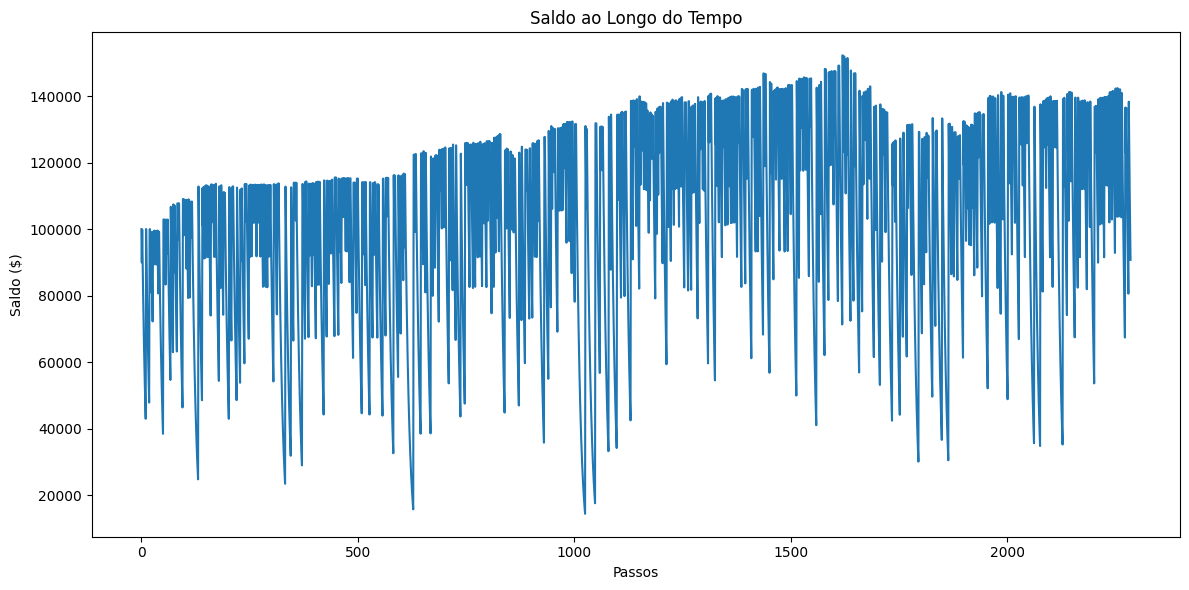

In [27]:
# Cria um gráfico mostrando o saldo ao longo do tempo
fig2, ax2 = plt.subplots(figsize = (12, 6)) 
ax2.plot(historico_saldo)

# Define o título e os rótulos dos eixos
ax2.set_title("Saldo ao Longo do Tempo")
ax2.set_xlabel("Passos")
ax2.set_ylabel("Saldo ($)")

# Ajusta o layout para evitar sobreposição
fig2.tight_layout()

# Exibe o gráfico
plt.show()

## Usando o Agente de Trading Para Períodos Futuros

In [28]:
# Carrega o modelo treinado
modelo_dsa_trading = PPO.load("modelo_dsa_trading")

In [29]:
# Baixa novos dados de ações do Yahoo Finance para simulação futura
# Usamos os dados até 13/09/2024 para tomar as decisões de trading nos dias seguintes
novo_df_dsa = yf.download("MSFT", start = "2024-08-24", end = "2024-09-24")

[*********************100%***********************]  1 of 1 completed


In [30]:
novo_df_dsa.head()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2024-08-26,411.083496,414.851447,408.946015,413.946739,13152800
2024-08-27,411.431458,411.948420,407.862355,410.457150,13492900
2024-08-28,408.210358,412.584744,404.939497,412.465447,14882700
2024-08-29,410.715668,419.593689,408.210345,412.525083,17045200
2024-08-30,414.712280,415.060219,409.731429,413.181235,24308300


In [31]:
novo_df_dsa.tail()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2024-09-17,432.617462,439.278481,429.754219,437.667914,18874200
2024-09-18,428.302734,433.492356,427.905068,432.468351,18898000
2024-09-19,436.136871,438.930515,434.357280,438.662097,21706600
2024-09-20,432.736786,436.683682,431.692909,434.675449,55167100
2024-09-23,430.987030,433.919843,427.885193,431.752538,15128900


In [32]:
# Define o tamanho da janela de observação
window_size = 10

In [33]:
# Define o frame_bound
frame_bound = (window_size, len(novo_df_dsa))

In [34]:
# Inicializa o ambiente com os novos dados e configurações (versão anterior do pacote gym)
#novo_dsaenv = gym.make('stocks-v0', 
#                       df = novo_df_dsa, 
#                       window_size = window_size, 
#                       frame_bound = frame_bound)

In [35]:
# Inicializa o ambiente com os novos dados e configurações (versão mais recente do pacote gym)
novo_dsaenv = CustomStocksEnv(df = novo_df_dsa,
                              window_size = window_size,
                              frame_bound = frame_bound)

In [36]:
# Reinicia o ambiente e obtém a primeira observação
observation, info = novo_dsaenv.reset(seed = 42)

In [37]:
# Inicializa variáveis de controle para o novo período de negociação
novo_saldo = 150000
novo_num_acoes_manter = 0
novo_historico_saldo = [novo_saldo]

In [38]:
# Assegure-se de inicializar como floats antes do loop
novo_num_acoes_manter = 0.0
novo_saldo = float(novo_saldo)

# Loop de negociação com os novos dados
while True:
    
    # O modelo faz a previsão da decisão a ser tomada
    action, _states = modelo_dsa_trading.predict(observation)

    # Obtém o preço atual da ação
    current_price = float(novo_dsaenv.unwrapped.prices[novo_dsaenv.unwrapped._current_tick])

    # Executa a decisão e obtém os novos dados do ambiente
    observation, reward, terminated, truncated, info = novo_dsaenv.step(action)

    # Define a quantia a ser negociada (10% do saldo)
    trade_amount = float(novo_saldo * 0.10)

    if action == Actions.Buy.value:
        
        # Calcula o número de ações a comprar
        shares_to_buy = float(trade_amount / current_price)
        novo_num_acoes_manter += shares_to_buy
        novo_saldo -= trade_amount
        print(f"Comprar {shares_to_buy:.2f} ações por ${current_price:.2f} cada uma | Novo Saldo: ${novo_saldo:.2f}")

    elif action == Actions.Sell.value and novo_num_acoes_manter > 0:

        # Vende todas as ações mantidas
        novo_saldo += novo_num_acoes_manter * current_price
        print(f"Vender {novo_num_acoes_manter:.2f} ações por ${current_price:.2f} cada uma | Novo Saldo: ${novo_saldo:.2f}")
        novo_num_acoes_manter = 0.001

    else:

        # Mantém as ações
        print(f"Manter | Preço da ação: ${current_price:.2f} | Saldo: ${novo_saldo:.2f}")

    # Atualiza o histórico do saldo
    novo_historico_saldo.append(novo_saldo)

    # Finaliza o loop se o episódio terminar
    if terminated or truncated:
        break

Comprar 36.43 ações por $411.79 cada uma | Novo Saldo: $135000.00
Vender 36.43 ações por $420.58 cada uma | Novo Saldo: $150320.13
Comprar 35.41 ações por $424.51 cada uma | Novo Saldo: $135288.12
Comprar 31.60 ações por $428.08 cada uma | Novo Saldo: $121759.31
Comprar 28.39 ações por $428.83 cada uma | Novo Saldo: $109583.38
Comprar 25.33 ações por $432.62 cada uma | Novo Saldo: $98625.04
Vender 120.74 ações por $428.30 cada uma | Novo Saldo: $150337.35
Comprar 34.47 ações por $436.14 cada uma | Novo Saldo: $135303.61
Vender 34.47 ações por $432.74 cada uma | Novo Saldo: $150220.58


In [39]:
# Se ainda houver ações no final, vendemos todas
if novo_num_acoes_manter > 0:
    novo_saldo += novo_num_acoes_manter * current_price
    print(f"Venda final: {novo_num_acoes_manter:.2f} ações por ${current_price:.2f} cada uma | Saldo Final: ${novo_saldo:.2f}")

Venda final: 0.00 ações por $432.74 cada uma | Saldo Final: $150221.01


In [40]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [41]:
#%watermark -v -m

In [42]:
#%watermark --iversions

# Fim